<a href="https://colab.research.google.com/github/ddong19/Image-Colorization/blob/master/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization


In [ ]:
!pip install torchsummary
!pip install transformers
!pip install kornia
!pip install torchmetrics
!pip install lpips
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM
import torch.utils.data as data

import lpips
from torchmetrics import PeakSignalNoiseRatio

import kornia

import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import albumentations as A
import matplotlib.pyplot as plt
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm

from skimage import io, color
import scipy.stats as stats

from google.colab import files

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

# Download Dataset

In [ ]:
# transforms = transforms.Compose([transforms.ToTensor()])

# for STL-10 dataset
IMG_SIZE = 96
dataset_un = torchvision.datasets.STL10('./data', 'unlabeled', download=True, transform=transforms.ToTensor())
# total = 100,000 cut the training set to 8000 and the test set to 2000, discard other 90k
dataset_train, dataset_test, _ = data.random_split(dataset_un, [int(len(dataset_un) * 0.08), int(len(dataset_un) * 0.02), 90000])

# for MIT Places365 dataset
# IMG_SIZE = 256
# dataset_train = torchvision.datasets.Places365('../data', split='train-standard', small=True, download=True, transform=transforms)
# dataset_test = torchvision.datasets.Places365('../data', split='val', small=True, download=True, transform=transforms)

print('# of samples for ulabeled, train, and test, {}, {}'.format(len(dataset_train), len(dataset_test)))
# print(type(dataset_un), type(dataset_train), type(dataset_test))

BATCH_SIZE = 64
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE)
# print(dir(dataloader_train))

Files already downloaded and verified
# of samples for ulabeled, train, and test, 8000, 2000


In [ ]:
files.upload()
pts_in_hull = np.load("pts_in_hull.npy")    # load the 313 ab color bins as defined in paper
# files.upload()
# prior_probs = np.load("prior_probs.npy")
# prior_probs = torch.tensor(prior_probs).to(device)
# prior_probs = prior_probs.reshape(1, 313, 1, 1)   # make it easier to broadcast later

<class 'torch.Tensor'> torch.Size([64, 3, 96, 96])
shape torch.Size([3, 786, 786])


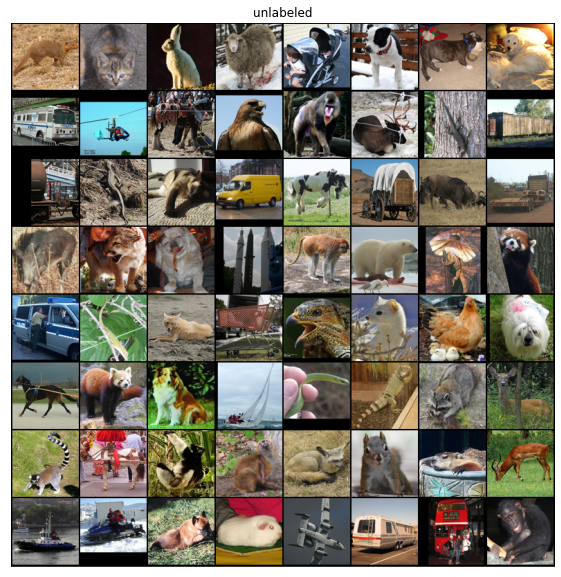

In [ ]:
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  print("shape", inp.shape)
  inp = inp.numpy().transpose((1, 2, 0))
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Visualize unlabeled train partition
inputs, _ = next(iter(dataloader_train))
out = torchvision.utils.make_grid(inputs, nrow=8)
print(type(inputs), inputs.shape)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title='unlabeled', ax=ax)

shape torch.Size([3, 786, 786])


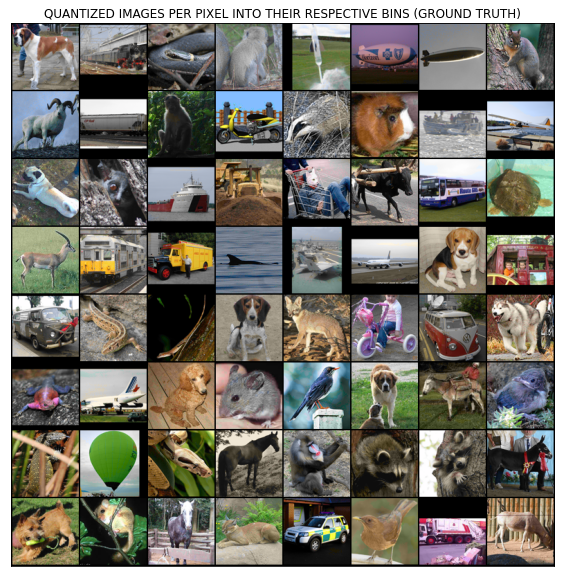

In [ ]:
import sklearn.neighbors as sknn

NUM_KNN_NEIGHBORS = 1
# feed in a list of (N, 2) inputs and (313, 2) points
# returns a numpy array with shape 
def quantize(inputs, to_points):
    neighbors = sknn.NearestNeighbors(n_neighbors=NUM_KNN_NEIGHBORS, algorithm='auto').fit(to_points)
    distances, indices = neighbors.kneighbors(inputs)
    # print(indices.shape)
    # assert(false)   # add in blurring with gaussian
    # end_points = np.array([to_points[i][0] for i in indices])
    return indices

def bins_to_ab(bins, to_points):
  # bins is a (64, 1, 96, 96) tensor
  return np.array([to_points[i] for i in bins])

# dir(dataloader_train.dataset)
inputs, _ = next(iter(dataloader_test))
inputs = kornia.color.rgb_to_lab(inputs)
L = inputs[:, 0:1, :, :]
ab = inputs[:, 1:, :, :]
ab = ab.reshape(-1, 2)
# print(ab.shape)
qinds = quantize(ab, pts_in_hull)
qpoints = bins_to_ab(qinds, pts_in_hull)
qpoints = torch.tensor(qpoints.reshape((BATCH_SIZE, 2, IMG_SIZE, IMG_SIZE)))

reconstructed = torch.cat((L, qpoints), dim=1)
reconstructed = kornia.color.lab_to_rgb(reconstructed)

out = torchvision.utils.make_grid(reconstructed, nrow=8)
fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title='QUANTIZED IMAGES PER PIXEL INTO THEIR RESPECTIVE BINS (GROUND TRUTH)', ax=ax)

In [ ]:
# test_img = inputs[0]
# test_img = torch.permute(test_img, (1, 2, 0))

# lab = color.rgb2lab(test_img)

# plt.figure()
# plt.imshow(test_img)

# print(test_img.shape)
# print(lab.shape)

# plt.figure()
# plt.imshow(lab[:,:,0]) 
# # print(lab[:10, :10, 0])
# plt.figure()
# plt.imshow(lab[:,:,1], cmap='RdYlGn_r')
# plt.figure()
# plt.imshow(lab[:,:,2], cmap='YlGnBu_r') 

# Autoencoder

In [ ]:
class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm


In [ ]:
from transformers.models import xlm
from re import X
class L2(BaseColor):
    def __init__(self):
        super(L2, self).__init__()

        model1=[nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.BatchNorm2d(32),]

        model2=[nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.BatchNorm2d(64),]

        model3=[nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.BatchNorm2d(128),]

        model4=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.BatchNorm2d(256),]

        model5=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.BatchNorm2d(512),]

        model6=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model6+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model6+=[nn.ReLU(True),]
        
        model7=[nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model7+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]
        model7+=[nn.ReLU(True)]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        
    def forward(self, input_l):
        x = self.model1(self.normalize_l(input_l))
        x = self.model2(x)
        x = self.model3(x)
        x = self.model4(x)
        x = self.model5(x)
        x = self.model6(x)
        x = self.model7(x)        

        out_reg = self.model_out(self.softmax(x))    
        res = self.unnormalize_ab(self.upsample(out_reg))
        return res

In [ ]:
from transformers.models import xlm
from re import X
class CrossEntropy(BaseColor):
    def __init__(self):
        super(CrossEntropy, self).__init__()

        model1=[nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.BatchNorm2d(32),]

        model2=[nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.BatchNorm2d(64),]

        model3=[nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.BatchNorm2d(128),]

        model4=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.BatchNorm2d(256),]

        model5=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.BatchNorm2d(512),]

        model6=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model6+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model6+=[nn.ReLU(True),]
        
        model7=[nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model7+=[nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=True),]
        model7+=[nn.ReLU(True)]

        model8=[nn.ConvTranspose2d(256, 313, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.Conv2d(313, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        # we have modified the architecture such that the final prediction outputs 313 channels
        # this is for class prediction on the 313 color bins—

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)


    def forward(self, input_l):
        x = self.model1(self.normalize_l(input_l))
        x = self.model2(x)
        x = self.model3(x)
        x = self.model4(x)
        x = self.model5(x)
        x = self.model6(x)
        x = self.model7(x)
        x = self.model8(x)
        
        return x

In [ ]:
def train_ae(model, dataloader, epochs=100):
    '''
    Train autoencoder model.

    Args:
        model: torch.nn.module.
        dataloader: DataLoader. The unlabeled partition of the STL dataset.
    '''

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    criterion2 = nn.MSELoss()
    loss_traj = []

    for epoch in tqdm_notebook(range(epochs)):

        loss_epoch = 0
        for rgb, _ in dataloader:

            ##############################################################################
            #                               YOUR CODE HERE                               #
            ##############################################################################
            # TODO: Train the autoencoder on one minibatch.                              #
            ##############################################################################
            lab = kornia.color.rgb_to_lab(rgb)

            L = lab[:, 0:1, :, :].cuda()
            ab = lab[:, 1:, :, :].cuda()
#-----------------------------------------------------------------------------------------------------------------------
            """
            # CODE FOR CROSS ENTROPY LOSS & BINNING

            ab = ab.reshape(-1, 2)
            gt_bins = quantize(ab, pts_in_hull)
            # gt_bins = torch.tensor(gt_bins).reshape((BATCH_SIZE, NUM_KNN_NEIGHBORS, IMG_SIZE, IMG_SIZE)).cuda()
            gt_bins = torch.tensor(gt_bins).reshape((64, IMG_SIZE, IMG_SIZE)).cuda()
            # print("here2", L.shape, gt_bins.shape)

            output = model(L)
            # print("here3", output.shape, gt_bins.shape)

            # output *= prior_probs   # adjust for rare colors
            # output += 110
            # output = F.relu(output)   # no negatives for cross entropy loss
            # gt_points += 110          # put all points  above 0

            loss = criterion(output, gt_bins)
            """
#-----------------------------------------------------------------------------------------------------------------------
            # CODE FOR OTHER LOSSES

            output = model(L).cuda()
            #print(output.shape)
            #print(ab.shape)
            loss = criterion2(output, ab)
#-----------------------------------------------------------------------------------------------------------------------

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ##############################################################################
            #                               END OF YOUR CODE                             #
            ##############################################################################
            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        
        # if epoch % 10 == 0:
        print('Epoch {}, loss {:.3f}'.format(epoch, loss_epoch))
        #     visualize_recon(model, dataloader)

    return model, loss_traj

In [ ]:
net = L2().to(device)
summary(net, (1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 24, 24]          18,496
              ReLU-5           [-1, 64, 24, 24]               0
       BatchNorm2d-6           [-1, 64, 24, 24]             128
            Conv2d-7          [-1, 128, 12, 12]          73,856
              ReLU-8          [-1, 128, 12, 12]               0
       BatchNorm2d-9          [-1, 128, 12, 12]             256
           Conv2d-10          [-1, 256, 12, 12]         295,168
             ReLU-11          [-1, 256, 12, 12]               0
      BatchNorm2d-12          [-1, 256, 12, 12]             512
           Conv2d-13          [-1, 512, 12, 12]       1,180,160
             ReLU-14          [-1, 512,

In [ ]:
net = CrossEntropy().to(device)
summary(net, (1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 64, 24, 24]          18,496
              ReLU-5           [-1, 64, 24, 24]               0
       BatchNorm2d-6           [-1, 64, 24, 24]             128
            Conv2d-7          [-1, 128, 12, 12]          73,856
              ReLU-8          [-1, 128, 12, 12]               0
       BatchNorm2d-9          [-1, 128, 12, 12]             256
           Conv2d-10          [-1, 256, 12, 12]         295,168
             ReLU-11          [-1, 256, 12, 12]               0
      BatchNorm2d-12          [-1, 256, 12, 12]             512
           Conv2d-13          [-1, 512, 12, 12]       1,180,160
             ReLU-14          [-1, 512,

In [ ]:
# train the model you want
train_ae(net, dataloader_train)

# GAN



In [ ]:
def normal_init(m, mean, std):
  """
  Helper function. Initialize model parameter with given mean and std.
  """
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()

class generator(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    ###########################################################################
    # TODO: Build your Unet generator encoder with the layer sizes            #
    # You can also check the size with the model summary below                #
    ###########################################################################

    conv1 = [nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)]
    conv2 = [
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128)
    ]
    conv3 = [
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256) 
    ]
    conv4 = [
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512)
    ]

    conv5 = [nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=1)]

    self.conv1 = nn.Sequential(*conv1)
    self.conv2 = nn.Sequential(*conv2)
    self.conv3 = nn.Sequential(*conv3)
    self.conv4 = nn.Sequential(*conv4)
    self.conv5 = nn.Sequential(*conv5)

    ###########################################################################
    # TODO: Build your Unet generator decoder with the layer sizes            #
    ###########################################################################

    deconv1 = [
        nn.ConvTranspose2d(512, 512, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm2d(512)
    ]
    deconv2 = [
        nn.ConvTranspose2d(512*2, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256)
    ]
    deconv3 = [
        nn.ConvTranspose2d(256*2, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128)
    ]
    deconv4 = [
        nn.ConvTranspose2d(128*2, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64)
    ]
    deconv5 = [nn.ConvTranspose2d(64*2, 2, kernel_size=4, stride=2, padding=1)]

    self.deconv1 = nn.Sequential(*deconv1)
    self.deconv2 = nn.Sequential(*deconv2)
    self.deconv3 = nn.Sequential(*deconv3)
    self.deconv4 = nn.Sequential(*deconv4)
    self.deconv5 = nn.Sequential(*deconv5)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    ###########################################################################
    # TODO: Implement the forward pass of generator                           #
    ###########################################################################
    # encoding
    e1 = F.leaky_relu(self.conv1(input))
    e2 = F.leaky_relu(self.conv2(e1), 0.2)
    e3 = F.leaky_relu(self.conv3(e2), 0.2)
    e4 = F.leaky_relu(self.conv4(e3), 0.2)
    e5 = self.conv5(e4)

    # print("input", input.shape)
    # print("e1", e1.shape)
    # print("e2", e2.shape)
    # print("e3", e3.shape)
    # print("e4", e4.shape)
    # print("e5", e5.shape)

    # # decoding
    # # Hint: you can use torch.cat to concatenate the decoder and the encoder inputs
    d1 = self.deconv1(F.relu(e5))
    # print("d1", d1.shape)
    d1 = torch.cat([d1, e4], 1) 
    d2 = self.deconv2(F.relu(d1))
    # print("d2", d2.shape)
    d2 = torch.cat([d2, e3], 1) 
    d3 = self.deconv3(F.relu(d2))
    # print("d3", d3.shape)
    d3 = torch.cat([d3, e2], 1) 
    d4 = self.deconv4(F.relu(d3))
    # print("d4", d1.shape)
    d4 = torch.cat([d4, e1], 1)
    d5 = self.deconv5(F.relu(d4))

    # original
    # d1 = self.deconv1(F.relu(e8))
    # d1 = torch.cat([d1, e7], 1) 
    # d2 = self.deconv2(F.relu(d1))
    # d2 = torch.cat([d2, e6], 1) 
    # d3 = self.deconv3(F.relu(d2))
    # d3 = torch.cat([d3, e5], 1) 
    # d4 = self.deconv4(F.relu(d3))
    # d4 = torch.cat([d4, e4], 1) 
    # d5 = self.deconv5(F.relu(d4))
    # d5 = torch.cat([d5, e3], 1) 
    # d6 = self.deconv6(F.relu(d5))
    # d6 = torch.cat([d6, e2], 1) 
    # d7 = self.deconv7(F.relu(d6))
    # d7 = torch.cat([d7, e1], 1) 
    # d8 = self.deconv8(F.relu(d7))

    output = F.tanh(d5)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return output

class discriminator(nn.Module):
  # initializers
  def __init__(self):
    super(discriminator, self).__init__()
    ###########################################################################
    # TODO: Build your CNN discriminator with the layer sizes                 #
    ###########################################################################

    conv1 = [nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)]
    conv2 = [
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128)
    ]
    conv3 = [
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256)
    ]
    conv4 = [
        nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm2d(512)
    ]
    self.conv1 = nn.Sequential(*conv1)
    self.conv2 = nn.Sequential(*conv2)
    self.conv3 = nn.Sequential(*conv3)
    self.conv4 = nn.Sequential(*conv4)

    self.one_channel = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    ###########################################################################
    # TODO: Implement the forward pass of discriminator                       #
    ###########################################################################

    l1 = self.conv1(input)
    l2 = self.conv2(F.leaky_relu(l1, 0.2))
    l3 = self.conv3(F.leaky_relu(l2, 0.2))
    l4 = self.conv4(F.leaky_relu(l3, 0.2))

    x = self.one_channel(l4)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return x

In [ ]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCEWithLogitsLoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train_GAN(G, D, dataloader, num_epochs=20, only_L1=False):
  hist_D_losses = []
  hist_G_losses = []
  hist_G_L1_losses = []
  ###########################################################################
  # TODO: Add Adam optimizer to generator and discriminator                 #
  # You will use lr=0.0002, beta=0.5, beta2=0.999                           #
  ###########################################################################
  G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
  D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
  ###########################################################################
  #                              END OF YOUR CODE                           #
  ###########################################################################

  print('training start!')
  start_time = time.time()
  for epoch in tqdm_notebook(range(num_epochs)):
    print('Start training epoch %d' % (epoch + 1))
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    num_iter = 0
    for rgb, _ in dataloader:

      lab = kornia.color.rgb_to_lab(rgb)

      L = lab[:, 0:1, :, :]
      ab = lab[:, 1:, :, :]
      
      L, ab = L.cuda(), ab.cuda()
      ###########################################################################
      # TODO: Implement training code for the discriminator.                    #
      # Recall that the loss is the mean of the loss for real images and fake   #
      # images, and made by some calculations with zeros and ones               #
      # We have defined the BCE_loss, which you might would like to use         #
      ###########################################################################

      D.zero_grad()

      # Create discriminator output
      real_img = torch.cat([L, ab], 1)
      fake_img = torch.cat([L, G(L).detach()], 1)
      D_result_real = D(real_img).squeeze()
      D_result_fake = D(fake_img).squeeze()

      D_train_loss = 0.5*BCE_loss(D_result_real, torch.ones(D_result_real.size()).cuda()) + 0.5*BCE_loss(D_result_fake, torch.zeros(D_result_fake.size()).cuda())
      D_train_loss.backward()
      D_optimizer.step()
      loss_D = D_train_loss.detach().item()

      ###########################################################################
      #                              END OF YOUR CODE                           #
      ###########################################################################   

      # Train the generator
      G.zero_grad()

      G_ab = G(L)
      D_input = torch.cat([L, G_ab], 1)
      D_result = D(D_input).squeeze()

      if only_L1:
        G_train_loss = L1_loss(G_ab, ab)
        hist_G_losses.append(L1_loss(G_ab, ab).detach().item())
      else:
        G_train_loss = BCE_loss(D_result, torch.ones(D_result.size()).cuda()) + 100 * L1_loss(G_ab, ab)
        hist_G_L1_losses.append(L1_loss(G_ab, ab).detach().item())
        hist_G_losses.append(BCE_loss(D_result, torch.ones(D_result.size()).cuda()).detach().item())
      
      G_train_loss.backward()
      G_optimizer.step()
      loss_G = G_train_loss.detach().item()

      D_losses.append(loss_D)
      hist_D_losses.append(loss_D)
      G_losses.append(loss_G)
      num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
    print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
    print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
    # if epoch == 0 or (epoch + 1) % 5 == 0:
    #   with torch.no_grad():
    #     show_result(G, fixed_x_, fixed_y_, (epoch+1))

  end_time = time.time()
  total_ptime = end_time - start_time

  return hist_D_losses, hist_G_losses, hist_G_L1_losses

In [ ]:
# print out the gan summary
G = generator().cuda()
D = discriminator().cuda()
summary(G, (1, 96, 96))
summary(D, (3, 96, 96))

# train_GAN(G, D, dataloader_train, num_epochs=50)

# Results and saving params

In [ ]:
# run this cell to save the trained parameters
torch.save(net.state_dict(), 'l2-long.pth')
files.download('l2-long.pth')

Loading paramters into model

In [ ]:
# del net2
# del net
# del newNet
torch.cuda.empty_cache()

# # if the net hasn't been defined yet, load it from params
# if 'net' not in locals() and 'net' not in globals():
files.upload()
state_dict = torch.load('cross-entropy (1).pth', map_location=device)
net.load_state_dict(state_dict)

<All keys matched successfully>

shape torch.Size([3, 786, 786])
shape torch.Size([3, 786, 786])


<Figure size 432x288 with 0 Axes>

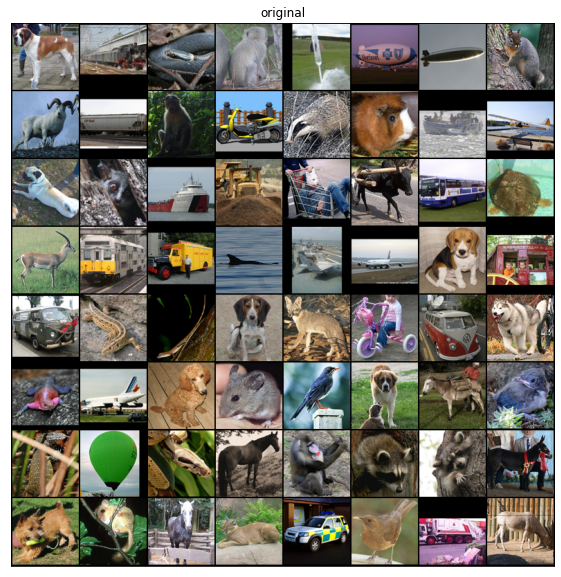

<Figure size 432x288 with 0 Axes>

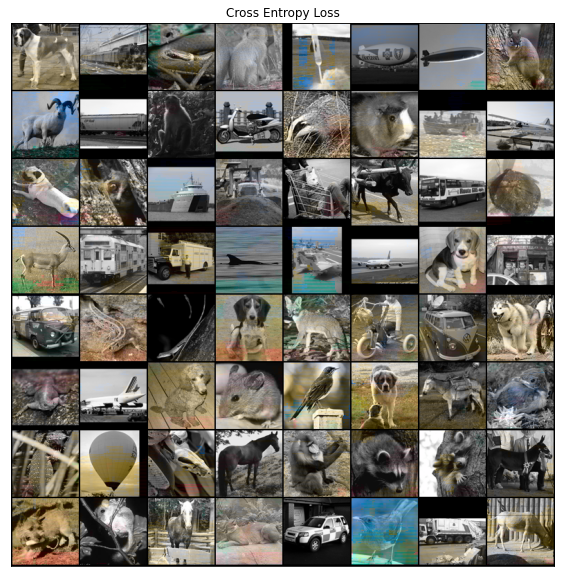

In [ ]:
originals, _ = next(iter(dataloader_test))
out = torchvision.utils.make_grid(originals, nrow=8)
# print(type(inputs), inputs.shape)

lab = kornia.color.rgb_to_lab(originals)
# lab = lab.cuda()

L = lab[:, 0:1, :, :].to(device)
ab = lab[:, 1:, :, :].to(device)

# FOR CROSS ENTROPY & BINNING
bins = net(L.cuda())
bins = torch.argmax(bins, dim=1)
ab_ = bins_to_ab(bins.cpu(), pts_in_hull)
ab_ = torch.tensor(ab_.reshape((BATCH_SIZE, 2, IMG_SIZE, IMG_SIZE)))

# FOR OTHER LOSSES
# ab_ = net(L).to(device)

# SHARED
Lab_ = torch.cat((L.cpu(), ab_), dim=1).cpu()
Lab_ = Lab_.detach()

generated = kornia.color.lab_to_rgb(Lab_)

originals = torchvision.utils.make_grid(originals, nrow=8)
generated = torchvision.utils.make_grid(generated, nrow=8)

# print(generated_img.shape)

plt.figure()
fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(originals, title='original', ax=ax)

plt.figure()
fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(generated, title='Cross Entropy Loss', ax=ax)

In [ ]:
# ! pip install torchvision[image]
# import lpips

# calculate ssim and psnr scores for the test dataset
ssim = SSIM()
psnr = PeakSignalNoiseRatio()
# lpips = lpips.LPIPS(net='vgg')

baseline_total_ssim = 0
baseline_total_psnr = 0
# baseline_total_lpips = 0
generated_total_ssim = 0
generated_total_psnr = 0
# generated_total_lpips = 0

total_count = 0

for rgb, _ in dataloader_test:
  if rgb.shape != (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE):
    print("skipped")
    continue

  total_count += 1

  lab = kornia.color.rgb_to_lab(rgb)

  L = lab[:, 0:1, :, :].to(device)
  # FOR CROSS ENTROPY & BINNING
  #bins = net(L.cuda())
  # bins = torch.argmax(bins, dim=1)
  # ab_ = bins_to_ab(bins.cpu(), pts_in_hull)
  # ab_ = torch.tensor(ab_.reshape((BATCH_SIZE, 2, IMG_SIZE, IMG_SIZE)))

  # FOR OTHER LOSSES
  ab_ = net(L).to(device)

  blank = torch.zeros(BATCH_SIZE, 2, IMG_SIZE, IMG_SIZE)
  # L with blank ab channels
  baseline_img = torch.cat( (L.cpu(), blank), 1)
  generated_img = torch.cat((L, ab_), dim=1).cpu()
  generated_img = generated_img.detach()

  baseline_img = kornia.color.lab_to_rgb(baseline_img)
  generated_img = kornia.color.lab_to_rgb(generated_img)

  baseline_total_ssim += ssim(baseline_img, rgb).item()
  psnr_add = psnr(baseline_img, rgb)
  print("psnr", psnr_add)
  baseline_total_psnr += psnr_add
  # baseline_total_lpips += lpips(baseline_img, rgb)[0]

  generated_total_ssim += ssim(generated_img, rgb).item()
  generated_total_psnr += psnr(generated_img, rgb).item()
  # generated_total_lpips += lpips(generated_img, rgb)[0]


# originals = torchvision.utils.make_grid(originals, nrow=8)
# generated = torchvision.utils.make_grid(generated, nrow=8)

# # print(generated_img.shape)

# plt.figure()
# fig, ax = plt.subplots(1, figsize=(10, 10))
# imshow(originals, title='original', ax=ax)

# plt.figure()
# fig, ax = plt.subplots(1, figsize=(10, 10))
# imshow(generated, title='L2 Loss', ax=ax)

  
print("ssim, baseline:", baseline_total_ssim / total_count, "generated:", generated_total_ssim / total_count)
print("psnr, baseline:", baseline_total_psnr / total_count, "generated:", generated_total_psnr / total_count)
# print("lpips, baseline:", baseline_total_lpips / total_count, "generated:", generated_total_lpips / total_count)

psnr tensor(22.2182)
psnr tensor(21.9077)
psnr tensor(21.6289)
psnr tensor(22.4576)
psnr tensor(21.1235)
psnr tensor(21.2788)
psnr tensor(21.2905)
psnr tensor(21.8105)
psnr tensor(21.2439)
psnr tensor(21.4933)
psnr tensor(21.7274)
psnr tensor(20.5285)
psnr tensor(20.7225)
psnr tensor(20.7899)
psnr tensor(23.2298)
psnr tensor(22.5041)
psnr tensor(22.1118)
psnr tensor(20.7050)
psnr tensor(20.7273)
psnr tensor(22.3263)
psnr tensor(21.6142)
psnr tensor(21.6985)
psnr tensor(22.3505)
psnr tensor(21.6764)
psnr tensor(22.5598)
psnr tensor(20.8335)
psnr tensor(21.1213)
psnr tensor(21.4675)
psnr tensor(20.7291)
psnr tensor(21.1287)
psnr tensor(22.0417)
skipped
ssim, baseline: 0.9331993883655917 generated: 0.9208063117919429
psnr, baseline: tensor(21.5821) generated: 22.09927257414787


In [ ]:
import lpips
lpips_metric = lpips.LPIPS(net='vgg')

baseline_total_lpips = 0
generated_total_lpips = 0

total_count = 0

for rgb, _ in dataloader_test:
  if rgb.shape != (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE):
    print("skipped")
    continue

  total_count += 1

  lab = kornia.color.rgb_to_lab(rgb)

  L = lab[:, 0:1, :, :].to(device)
  # FOR CROSS ENTROPY & BINNING
  bins = net(L.cuda())
  bins = torch.argmax(bins, dim=1)
  ab_ = bins_to_ab(bins.cpu(), pts_in_hull)
  ab_ = torch.tensor(ab_.reshape((BATCH_SIZE, 2, IMG_SIZE, IMG_SIZE)))

  # FOR OTHER LOSSES
  # ab_ = net(L).to(device)

  # SHARED
  blank = torch.zeros(BATCH_SIZE, 2, IMG_SIZE, IMG_SIZE)
  # L with blank ab channels
  baseline_img = torch.cat( (L.cpu(), blank), 1)
  generated_img = torch.cat((L.cpu(), ab_), dim=1).cpu()
  generated_img = generated_img.detach()

  baseline_img = kornia.color.lab_to_rgb(baseline_img)
  generated_img = kornia.color.lab_to_rgb(generated_img)

  # baseline_total_ssim += ssim(baseline_img, rgb).item()
  # psnr_add = psnr(baseline_img, rgb)
  # print("psnr", psnr_add)
  # baseline_total_psnr += psnr_add
  baseline_lpips = lpips_metric(baseline_img, rgb)[0]
  baseline_total_lpips += baseline_lpips
  print(baseline_lpips)

  # generated_total_ssim += ssim(generated_img, rgb).item()
  # generated_total_psnr += psnr(generated_img, rgb).item()
  generated_lpips = lpips_metric(generated_img, rgb)[0]
  generated_total_lpips += generated_lpips
  print(generated_lpips)

  
print("lpips, baseline:", baseline_total_lpips / total_count, "generated:", generated_total_lpips / total_count)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/vgg.pth
tensor([[[0.1144]]], grad_fn=<SelectBackward0>)
tensor([[[0.1437]]], grad_fn=<SelectBackward0>)
tensor([[[0.0919]]], grad_fn=<SelectBackward0>)
tensor([[[0.1331]]], grad_fn=<SelectBackward0>)
tensor([[[0.1873]]], grad_fn=<SelectBackward0>)
tensor([[[0.1579]]], grad_fn=<SelectBackward0>)
tensor([[[0.1907]]], grad_fn=<SelectBackward0>)
tensor([[[0.1719]]], grad_fn=<SelectBackward0>)
